In [0]:
gooimport networkx as nx
import requests
import json
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import pickle
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Define Functions

In [0]:
def get_article_revisions(title):
    revisions = []
    # create a base url for the api and then a normal url which is initially
    # just a copy of it
    # The following line is what the requests call is doing, basically.
    # "http://en.wikipedia.org/w/api.php/?action=query&titles={0}&prop=revisions&rvprop=flags|timestamp|user|size|ids&rvlimit=500&format=json&continue=".format(title)
    wp_api_url = "http://en.wikipedia.org/w/api.php/"

    # list_parameters = {'action' : 'query',
    #               'generator' : 'allpages',
    #               'prop' : 'pageassessments',
    #               'rvprop' : 'flags|timestamp|user|size|ids',
    #               'rvlimit' : 500,
    #               'format' : 'json',
    #               'continue' : ''}

    title_parameters = {'action' : 'query',
                  'titles' : title,
                  'prop' : 'revisions',
                  'rvprop' : 'flags|timestamp|user|size|ids',
                  'rvlimit' : 500,
                  'format' : 'json',
                  'continue' : '' }
    while True:
        # the first line open the urls but also handles unicode urls
        call = requests.get(wp_api_url, params=title_parameters)
        # call = requests.get(wp_api_url, params=list_parameters)
        api_answer = call.json()

        # get the list of pages from the json object
        pages = api_answer["query"]["pages"]

        # for every page, (there should always be only one) get its revisions:
        for page in pages.keys():
            query_revisions = pages[page]["revisions"]

            # Append every revision to the revisions list
            for rev in query_revisions:
                revisions.append(rev)

        # 'continue' tells us there's more revisions to add
        if 'continue' in api_answer:
            # replace the 'continue' parameter with the contents of the
            # api_answer dictionary.
            title_parameters.update(api_answer['continue'])
            # list_parameters.update(api_answer['continue'])
        else:
            break

    return(revisions)

In [0]:
def get_ores_scores(title):
  rev_id = get_article_revisions(title)[-1]['revid']
  response = requests.get("https://ores.wikimedia.org/v3/scores/{}/{}/{}".format("enwiki", rev_id, "articlequality"))
  return response.json()['enwiki']['scores'][str(rev_id)]['articlequality']['score']["probability"]

In [0]:
def get_ores_prediction(title):
  rev_id = get_article_revisions(title)[-1]['revid']
  response = requests.get("https://ores.wikimedia.org/v3/scores/{}/{}/{}".format("enwiki", rev_id, "articlequality"))
  return response.json()['enwiki']['scores'][str(rev_id)]['articlequality']['score']['prediction']

In [0]:
def get_ores_score(title):
  d = get_ores_scores(title)
  return d['FA'] + .8*d['GA'] + .6*d['B'] + .4*d['C'] + .2*d['Start']

In [0]:
def get_ores_dict(title):
  rev_id = get_article_revisions(title)[-1]['revid']
  response = requests.get("https://ores.wikimedia.org/v3/scores/{}/{}/{}".format("enwiki", rev_id, "articlequality"))
  response = response.json()['enwiki']['scores'][str(rev_id)]['articlequality']['score']
  d = response["probability"]
  return {'title' : title,
          'P(FA)': d['FA'], 
          'P(GA)': d['GA'], 
          'P(B)': d['B'], 
          'P(C)': d['C'], 
          'P(Start)': d['Start'], 
          'P(Stub)': d['Stub'], 
          'ORES_Guess': response['prediction'], 
          'ORES_Score': d['FA'] + .8*d['GA'] + .6*d['B'] + .4*d['C'] + .2*d['Start']          
          }

# Create DF

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/DF-All-FA900.pkl', 'rb') as f:
  df = pickle.load(f)

In [0]:
dict_lst = []
for title in df["title"]:
  dict_lst.append(get_ores_dict(title))

In [0]:
dict_lst

In [0]:
df_ores = pd.DataFrame(dict_lst)

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_all_ores_info.pkl', 'wb') as f:
    #f.write(df_fa.to_csv(index=False))
    pickle.dump(df_ores, f)

In [0]:
df_ores.head()

,P(FA),P(GA),P(B),P(C),P(Start),P(Stub),ORES_Guess,ORES_Score
0,0.002971,0.004535,0.100961,0.067618,0.432991,0.390922,Start,0.180822
1,0.001775,0.002622,0.020635,0.013197,0.045199,0.916572,Stub,0.030572
2,0.004032,0.006026,0.070716,0.038037,0.722840,0.158349,Start,0.211065
3,0.002457,0.004042,0.030508,0.025804,0.069646,0.867542,Stub,0.048247
4,0.004233,0.006817,0.043614,0.037566,0.399302,0.508468,Stub,0.130741


# Examples

In [0]:
get_ores_dict("Cleopatra")

{'ORES_Guess': 'Stub',
 'ORES_Score': 0.02628668333016067,
 'P(B)': 0.014982065985694053,
 'P(C)': 0.012164338449205803,
 'P(FA)': 0.0018267229565853964,
 'P(GA)': 0.0026175546170353866,
 'P(Start)': 0.042554708544241066,
 'P(Stub)': 0.9258546094472383}

In [0]:
get_ores_scores("Sideshow Bob")

{'B': 0.01682302830604238,
 'C': 0.015330563098724367,
 'FA': 0.0022523333805061986,
 'GA': 0.003322217094662429,
 'Start': 0.06453183299662224,
 'Stub': 0.8977400251234422}

In [0]:
get_ores_prediction("Biology")

'Start'

In [0]:
get_ores_score("Biology")

0.22030056503715578

# Applying to DFs

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/DF-All-Fullish.pkl', 'rb') as f:
  df = pickle.load(f)

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/smallDF/small_DF-All.pkl', 'rb') as f:
  df_small = pickle.load(f)

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/smallDF/small_C-ClassDF.pkl', 'rb') as f:
  df_small_c = pickle.load(f)

In [0]:
df_small_c['ORES'] = df_small_c.apply(lambda row: get_ores_score(row.name), axis=1)

In [0]:
df_small_c.describe()

,diameter,closeness,clustering,betweenness,edit count,editor count,article size,ORES
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,52.540000,0.091968,0.035044,0.030495,1776.860000,831.970000,43098.260000,0.093171
std,22.912843,0.033757,0.022236,0.028974,2108.541135,768.078127,30355.021372,0.070342
min,22.000000,0.024309,0.003086,0.001117,147.000000,77.000000,5635.000000,0.017026
25%,37.750000,0.069026,0.018755,0.009388,717.000000,369.250000,25702.750000,0.032557
50%,49.000000,0.090579,0.028002,0.017944,1179.000000,580.500000,39373.500000,0.073560
75%,59.250000,0.113783,0.045698,0.044851,2379.750000,1190.750000,58168.000000,0.131104
max,187.000000,0.164506,0.102638,0.123714,16673.000000,5348.000000,257486.000000,0.357147


In [0]:
df['ORES Score'] = df.apply(lambda row: get_ores_score(row.name), axis=1)

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_all_ores.pkl', 'wb') as f:
  pickle.dump(df,f)

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_all_ores.pkl', 'rb') as f:
  df = pickle.load(f)

In [0]:
 df

,diameter,closeness,clustering,betweenness,edit count,editor count,article size,class,class_alpha,ORES Score
title,,,,,,,,,,
Chess,26,0.154242,0.067933,0.001672,9559,3490,134256,FA,FA,0.180822
Archaeopteryx,32,0.153966,0.066057,0.005054,2871,1184,94764,FA,FA,0.030572
Genetics,39,0.131014,0.033090,0.003019,4844,2359,89884,FA,FA,0.211065
P. G. Wodehouse,37,0.122061,0.056904,0.007460,2468,1042,98725,FA,FA,0.048247
Josquin des Prez,24,0.170658,0.047585,0.009610,1291,561,54797,FA,FA,0.130741
...,...,...,...,...,...,...,...,...,...,...
Emma (novel),48,0.080656,0.014877,0.007770,2595,1565,76489,C,xC,0.157117
Vanuatu,40,0.106024,0.026519,0.005894,2750,1561,86414,C,xC,0.016179
Multiple inheritance,84,0.034046,0.012661,0.094954,453,315,19641,C,xC,0.048169


In [0]:
df.groupby("class_alpha").mean()

,diameter,closeness,clustering,betweenness,edit count,editor count,article size,ORES Score
class_alpha,,,,,,,,
FA,38.383094,0.133415,0.064828,0.011590,4062.571942,1579.230216,98329.383094,0.099182
GA,42.760761,0.116709,0.052815,0.025357,3122.257257,1278.454454,80724.185185,0.082066
xB,45.397796,0.105547,0.040837,0.026161,2352.775551,1068.490982,63213.722445,0.096662
xC,48.134134,0.093743,0.034688,0.045794,1705.273273,806.961962,46795.170170,0.088822


# Visualize

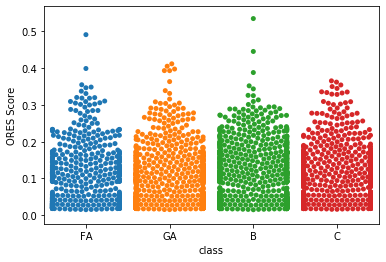

In [0]:
sns.swarmplot(data=df, y='ORES Score', x="class", order=["FA", "GA", "B", "C"])

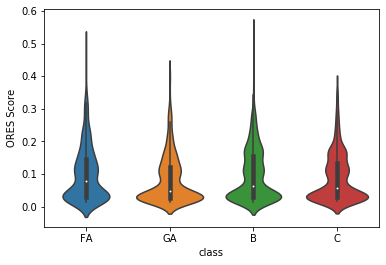

In [0]:
sns.violinplot(x="class", y="ORES Score", data=df)

# New DF


In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/DF-All-FA900.pkl', 'rb') as f:
  df = pickle.load(f)

In [0]:
df.head()

,title,diameter,closeness,clustering,betweenness,edit count,editor count,article size,class,class_alpha
0,Chess,26,0.154242,0.067933,0.001672,9559,3490,134256,FA,FA
1,Archaeopteryx,32,0.153966,0.066057,0.005054,2871,1184,94764,FA,FA
2,Genetics,39,0.131014,0.033090,0.003019,4844,2359,89884,FA,FA
3,P. G. Wodehouse,37,0.122061,0.056904,0.007460,2468,1042,98725,FA,FA
4,Josquin des Prez,24,0.170658,0.047585,0.009610,1291,561,54797,FA,FA


In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_all_ores_info.pkl', 'rb') as f:
  df_ores = pickle.load(f)

In [0]:
df_ores.head()

,P(FA),P(GA),P(B),P(C),P(Start),P(Stub),ORES_Guess,ORES_Score
0,0.002971,0.004535,0.100961,0.067618,0.432991,0.390922,Start,0.180822
1,0.001775,0.002622,0.020635,0.013197,0.045199,0.916572,Stub,0.030572
2,0.004032,0.006026,0.070716,0.038037,0.722840,0.158349,Start,0.211065
3,0.002457,0.004042,0.030508,0.025804,0.069646,0.867542,Stub,0.048247
4,0.004233,0.006817,0.043614,0.037566,0.399302,0.508468,Stub,0.130741


In [0]:
df_full = df.join(df_ores)

In [0]:
df_full.head()

,title,diameter,closeness,clustering,betweenness,edit count,editor count,article size,class,class_alpha,P(FA),P(GA),P(B),P(C),P(Start),P(Stub),ORES_Guess,ORES_Score
0,Chess,26,0.154242,0.067933,0.001672,9559,3490,134256,FA,FA,0.002971,0.004535,0.100961,0.067618,0.432991,0.390922,Start,0.180822
1,Archaeopteryx,32,0.153966,0.066057,0.005054,2871,1184,94764,FA,FA,0.001775,0.002622,0.020635,0.013197,0.045199,0.916572,Stub,0.030572
2,Genetics,39,0.131014,0.033090,0.003019,4844,2359,89884,FA,FA,0.004032,0.006026,0.070716,0.038037,0.722840,0.158349,Start,0.211065
3,P. G. Wodehouse,37,0.122061,0.056904,0.007460,2468,1042,98725,FA,FA,0.002457,0.004042,0.030508,0.025804,0.069646,0.867542,Stub,0.048247
4,Josquin des Prez,24,0.170658,0.047585,0.009610,1291,561,54797,FA,FA,0.004233,0.006817,0.043614,0.037566,0.399302,0.508468,Stub,0.130741


In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_ores_allCols.pkl', 'wb') as f:
    pickle.dump(df_full, f)

# Compare ORES to priors

In [0]:
with open('/content/drive/Shared drives/CS Comps: Wikipedia Article Trajectories /data/df_ores_allCols.pkl', 'rb') as f:
    df = pickle.load(f)

In [0]:
df.groupby(["class_alpha", "ORES_Guess"])["ORES_Score"].describe()

count      mean       std  ...       50%       75%       max
class_alpha ORES_Guess                             ...                              
FA          B             4.0  0.420091  0.049690  ...  0.405897  0.432226  0.491353
            Start       258.0  0.204042  0.054430  ...  0.190738  0.233521  0.393539
            Stub        642.0  0.057885  0.038205  ...  0.040304  0.093844  0.151077
GA          B             5.0  0.400459  0.008107  ...  0.397883  0.405448  0.412022
            Start       197.0  0.194992  0.050920  ...  0.180294  0.222042  0.363652
            Stub        797.0  0.052156  0.037443  ...  0.035045  0.077773  0.290938
xB          B             3.0  0.456362  0.074016  ...  0.445655  0.490402  0.535148
            Start       288.0  0.198026  0.045427  ...  0.182968  0.226923  0.352131
            Stub        707.0  0.053845  0.036534  ...  0.036346  0.088616  0.193809
xC          B             2.0  0.363932  0.002438  ...  0.363932  0.364794  0.365656
            Start       243.0  0.193288  0.050866  ...  0.171941  0.217510  0.354468
            Stub        754.0  0.054424  0.037118  ...  0.036757  0.087561  0.209807

[12 rows x 8 columns]

In [0]:
df.groupby(["ORES_Guess"])["title"].describe()

,count,unique,top,freq
ORES_Guess,,,,
B,14,14,"Gilbert du Motier, Marquis de Lafayette",1
Start,986,985,Theramenes,2
Stub,2900,2899,Battle of Dien Bien Phu,2


In [0]:
print("B:", 14 / 3900)
print("Start:", 986 / 3900) 
print("Stub:", 2900/ 3900) 

B: 0.0035897435897435897
Start: 0.2528205128205128
Stub: 0.7435897435897436


In [0]:
true_count = [6866, 33420, 131091, 332133, 1826843, 3390074]
probability = [x / sum (true_count) for x in true_count]
for x in probability: 
  print(x)

0.001200260050517208
0.005842221218800624
0.02291629628347674
0.0580608755255508
0.31935430694247124
0.5926260399791834
